# Flux Footprint Climatology Tutorial

This notebook demonstrates how to use **all** public methods in `ffp_xr.py` with the provided AmeriFlux half‑hourly dataset. It covers:

1. Loading and preparing the data
2. Instantiating `ffp_climatology_new`
3. Running the core footprint calculation (`calc_xr_footprint`)
4. Visualising the footprint climatology
5. Extracting source‑area contours via `smooth_and_contour`
6. Using the convenience wrapper `run`
7. Triggering and handling validation errors (`raise_ffp_exception`)


In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

# make plots a little larger
plt.rcParams['figure.figsize'] = (6, 5)

# import the module (it's in the same directory)
import importlib, sys, os

# Add current directory to sys.path so Python can find improved_ffp.py
sys.path.insert(0, os.path.abspath("../../src"))  # adjust path as needed
from fluxfootprints import ffp_xr


## 1. Load the half‑hourly AmeriFlux data

In [2]:
csv_path = Path('US-UTE_HH_202406241430_202409251400.csv')
df_raw = pd.read_csv(csv_path, parse_dates=['TIMESTAMP_START'])
df_raw = df_raw.rename(columns={'TIMESTAMP_START':'TIMESTAMP'})
df_raw = df_raw.set_index('TIMESTAMP')
df_raw.head()

,datetime_start,TIMESTAMP_END,CO2,CO2_SIGMA,H2O,H2O_SIGMA,FC,FC_SSITC_TEST,LE,LE_SSITC_TEST,...,TA_1_2_1,RH_1_2_1,T_DP_1_2_1,TA_1_3_1,RH_1_3_1,T_DP_1_3_1,TA_1_4_1,PBLH_F,TS_2_1_1,SWC_2_1_1
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2024-06-24 14:30:00,2024-06-24 14:30:00,202406241500,427.0199,0.628133,17.26862,1.019290,0.069210,-9999.0,156.40850,-9999.0,...,29.95141,33.26877,12.052600,30.32464,33.45364,12.46181,30.06976,1665.4670,25.72815,22.44161
2024-06-24 15:00:00,2024-06-24 15:00:00,202406241530,425.9499,1.019297,15.18936,0.703052,0.285446,-9999.0,138.30920,-9999.0,...,30.02516,29.22197,10.155240,30.35956,29.77183,10.72635,30.13765,1765.9350,25.52736,22.41975
2024-06-24 15:30:00,2024-06-24 15:30:00,202406241600,426.4163,1.965228,14.87533,0.808026,1.081928,-9999.0,154.11530,-9999.0,...,30.24634,28.28498,9.838229,30.69433,28.63222,10.41335,30.40344,1495.7350,25.12511,22.32785
2024-06-24 16:00:00,2024-06-24 16:00:00,202406241630,426.0534,2.665907,15.61140,1.002919,0.519664,-9999.0,135.56180,-9999.0,...,30.75179,28.75255,10.538220,31.14621,29.16225,11.09066,30.90061,1491.0620,24.63557,22.18172
2024-06-24 16:30:00,2024-06-24 16:30:00,202406241700,427.8476,1.102921,15.21034,0.703084,1.147608,-9999.0,95.06287,-9999.0,...,29.16274,30.77158,10.165810,29.57434,30.96792,10.63069,29.30510,341.9711,24.14865,22.03216


### Minimal column mapping required by `ffp_climatology_new`
The class looks for the following names:

| Required | Typical AmeriFlux column |
|----------|--------------------------|
| `V_SIGMA` | `V_SIGMA` |
| `USTAR`   | `USTAR`   |
| `wd` (wind dir) | `WD` |
| `MO_LENGTH`| `MO_LENGTH` |
| `ws` (wind speed) | `WS` |

If your file uses different headers, rename them accordingly:

In [3]:
df = df_raw.rename(columns={'WD':'wd', 'WS':'ws'})  # already matches other names
required = ['V_SIGMA','USTAR','wd','MO_LENGTH','ws']
assert all([c in df.columns for c in required]), 'Missing required columns'


## 2. Instantiate `ffp_climatology_new`

In [4]:
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [5]:
# We only keep a short slice (e.g. two weeks) to speed up this demo
demo_df = df.loc['2024-07-01':'2024-07-14'].copy()
clim = ffp_xr.ffp_climatology_new(demo_df,
                                  dx=20, dy=20,  # coarser grid for speed
                                  logger=logger,
                                  verbosity=1,)
print(f"Input time steps: {clim.ts_len}")

Input time steps: 670


### 2.1 (Optional) Re‑running `prep_df_fields`
You can re‑compute derived fields (e.g. if you want to test a different canopy height):

In [6]:
# e.g. double the assumed canopy height
clim.prep_df_fields(h_c=0.4)  # 0.4 m crop height


## 3. Core footprint calculation – `calc_xr_footprint`

In [7]:
clim.calc_xr_footprint()
clim.fclim_2d  # this is an xarray.DataArray

c:\Users\paulinkenbrandt\.conda\envs\py313\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


<xarray.DataArray (x: 101, y: 101)> Size: 82kB
array([[9.18813828e-11, 9.70087771e-11, 1.04905085e-10, ...,
        6.84245266e-10, 6.71603568e-10, 6.64331771e-10],
       [9.20988210e-11, 9.66552350e-11, 1.04030131e-10, ...,
        7.05171829e-10, 6.95290992e-10, 6.90450146e-10],
       [9.38352142e-11, 9.72782826e-11, 1.03431515e-10, ...,
        7.40324868e-10, 7.35460314e-10, 7.34605864e-10],
       ...,
       [1.38426068e-09, 1.42028323e-09, 1.47024665e-09, ...,
        3.80151431e-10, 3.81763645e-10, 3.79734592e-10],
       [1.35874431e-09, 1.38854145e-09, 1.43102746e-09, ...,
        3.53371774e-10, 3.61628419e-10, 3.64838998e-10],
       [1.33746507e-09, 1.36385270e-09, 1.40260356e-09, ...,
        3.33333019e-10, 3.45202333e-10, 3.51459485e-10]], shape=(101, 101))
Coordinates:
  * x        (x) float64 808B -1e+03 -980.0 -960.0 -940.0 ... 960.0 980.0 1e+03
  * y        (y) float64 808B -1e+03 -980.0 -960.0 -940.0 ... 960.0 980.0 1e+03

### Visualise the 2‑D footprint climatology

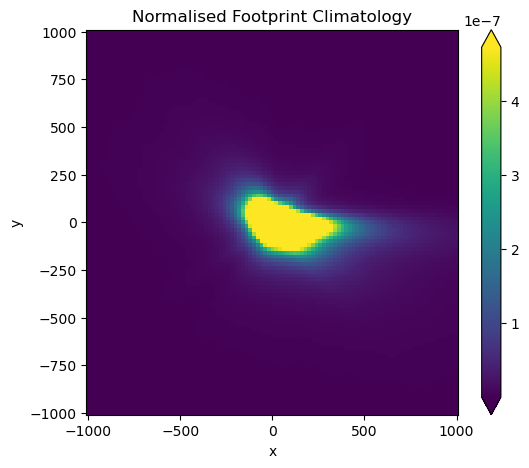

In [8]:
clim.fclim_2d.plot(x='x', y='y', cmap='viridis', robust=True)
plt.title('Normalised Footprint Climatology')
plt.show()

## 4. Extract source‑area contours – `smooth_and_contour`

In [9]:
contours_ds = clim.smooth_and_contour(rs=[0.5, 0.8])
contours_ds


<xarray.Dataset> Size: 654kB
Dimensions:     (x: 101, y: 101)
Coordinates:
  * x           (x) float64 808B -1e+03 -980.0 -960.0 ... 960.0 980.0 1e+03
  * y           (y) float64 808B -1e+03 -980.0 -960.0 ... 960.0 980.0 1e+03
Data variables:
    contour_10  (x, y) float64 82kB 0.0 0.0 0.0 0.0 ... 0.9999 0.9999 1.0 1.0
    contour_20  (x, y) float64 82kB 0.0 0.0 0.0 0.0 ... 0.9999 0.9999 1.0 1.0
    contour_30  (x, y) float64 82kB 0.0 0.0 0.0 0.0 ... 0.9999 0.9999 1.0 1.0
    contour_40  (x, y) float64 82kB 0.0 0.0 0.0 0.0 ... 0.9999 0.9999 1.0 1.0
    contour_50  (x, y) float64 82kB 0.0 0.0 0.0 0.0 ... 0.9999 0.9999 1.0 1.0
    contour_60  (x, y) float64 82kB 0.0 0.0 0.0 0.0 ... 0.9999 0.9999 1.0 1.0
    contour_70  (x, y) float64 82kB 0.0 0.0 0.0 0.0 ... 0.9999 0.9999 1.0 1.0
    contour_80  (x, y) float64 82kB 0.0 0.0 0.0 0.0 ... 0.9999 0.9999 1.0 1.0

Plot the 80 % contour:

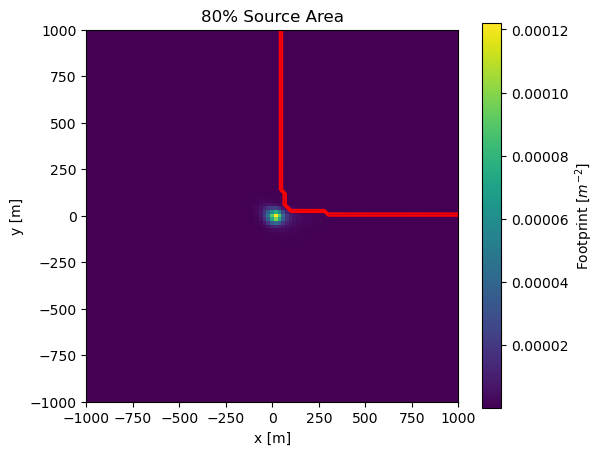

In [11]:
plt.contour(clim.xv, clim.yv, contours_ds['contour_80'], levels=[0.0, 0.5], colors='red')
plt.imshow(clim.fclim_2d.T, origin='lower',
           extent=[clim.x.min(), clim.x.max(), clim.y.min(), clim.y.max()],
           cmap='viridis')
plt.title('80% Source Area')
plt.xlabel('x [m]'); plt.ylabel('y [m]')
plt.colorbar(label='Footprint [$m^{-2}$]')
plt.show()

## 5. One‑shot convenience – `run`

In [13]:
quick = ffp_xr.ffp_climatology_new(demo_df, dx=20, dy=20, verbosity=0, logger=logger)
quick.run()
print(list(quick.__dict__.keys())[:10])  # peek at attributes


c:\Users\paulinkenbrandt\.conda\envs\py313\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


['fclim_2d', 'df', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y', 'rotated_theta', 'a']


## 6. Error handling via `raise_ffp_exception`
Here we *deliberately* drop a required column to provoke an error:

In [15]:
try:
    bad_df = demo_df.drop(columns=['USTAR'])
    ffp_xr.ffp_climatology_new(bad_df, verbosity=2,logger=logger)
except ValueError as e:
    print('Caught expected error:', e)

2025-06-22 20:58:29,071 - ERROR - Error 1: At least one required parameter is missing. Check the inputs.


Error 1: At least one required parameter is missing. Check the inputs.
Caught expected error: FFP Exception 1: At least one required parameter is missing. Check the inputs.


## 7. Next steps
* Swap in the full half‑hourly DataFrame to build multi‑month climatologies.
* Use a finer grid (`dx`, `dy`) for higher‑resolution footprints.
* Overlay the footprints with land‑cover maps or remote‑sensing layers to study source contributions.